In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

# Lets look into building footprints dataset to get a more accurate representation of building obstruction to the camera fields of view


## [NYC Building Footprints](https://data.cityofnewyork.us/resource/qb5r-6dgf.json)

The metadata for this dataset can be found [here](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md).

### Script Objectives:

This script looks to create a more accurate mask of the building footprints in brooklyn to clip the camera buffer zones.

#### Input Files:

 * Building Footprints: Socrata API url `https://data.cityofnewyork.us/resource/qb5r-6dgf.json`

 * MapPLUTO: Map PLUTO data is stored outside of the repository due to GitHub's file size constraints. The path to my data is as follows:

    `path = os.getcwd()
    parent = os.path.dirname(os.path.dirname(path))
    mappluto = gpd.read_file(parent+'/CapstoneData/nyc_mappluto_22v2_shp/MapPLUTO.shp)
    `

Please be sure to update this path if your data is stored in a different structure on your local device. [Introduction to MapPLUTO](https://nycplanning.github.io/db-pluto/#/)

The Primary Land Use Tax Lot Output (PLUTO™) data file contains extensive land use and geographic data at the tax lot level in a comma-delimited file. The PLUTO tax lot data files contain over seventy data fields derived from data files maintained by the Department of City Planning (DCP), Department of Finance (DOF), Department of Citywide Administrative Services (DCAS), and Landmarks Preservation Commission (LPC). DCP has created additional fields based on data obtained from one or more of the major data sources. PLUTO data files contain three basic types of data:

* Tax Lot Characteristics;
* Building Characteristics; and
* Geographic/Political/Administrative Districts.


In [8]:
#use SODA API to get building footprints
url = 'https://data.cityofnewyork.us/resource/qb5r-6dgf.json'

query = (url+'?'
        "$select=*"
        "&$where=starts_with(bin::text, '3')"
        "&$limit=5000000")
query = query.replace(" ", "%20")
print(query)
response = urllib.request.urlopen(query)
data = json.loads(response.read())

for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
building_gdf = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
building_gdf = building_gdf.drop(columns = ['the_geom'])
building_gdf.head()

https://data.cityofnewyork.us/resource/qb5r-6dgf.json?$select=*&$where=starts_with(bin::text,%20'3')&$limit=5000000


,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,name
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,3065220021,3065220021,Photogramm,"MULTIPOLYGON (((-73.96665 40.62600, -73.96685 ...",NaN
1,3245111,1928,2017-08-22T00:00:00.000,Constructed,786626,37.5,2100,6,0.0,0.0,3086910048,3086910048,Photogramm,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",NaN
2,3088045,1905,2017-08-22T00:00:00.000,Constructed,636591,27.03,2100,37,0.0,0.0,3039550030,3039550030,Photogramm,"MULTIPOLYGON (((-73.88377 40.67953, -73.88387 ...",NaN
3,3401793,1920,2017-08-17T00:00:00.000,Constructed,1204424,15.04,5110,25,0.0,0.0,3062890021,3062890021,Photogramm,"MULTIPOLYGON (((-73.98955 40.60449, -73.98959 ...",NaN
4,3099098,1928,2017-08-22T00:00:00.000,Constructed,111394,67.91,2100,37,0.0,0.0,3045880001,3045880001,Photogramm,"MULTIPOLYGON (((-73.93395 40.66244, -73.93395 ...",NaN


In [9]:
#load camera data
path = os.getcwd()
parent = os.path.dirname(os.path.dirname(path))
print(parent)
mappluto = gpd.read_file(parent+'/CapstoneData/nyc_mappluto_22v2_shp/MapPLUTO.shp')

/Users/lizjohnson/Desktop/Personal_Projects


In [10]:
mappluto.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [11]:
bk_mappluto = mappluto[mappluto['Borough'] == 'BK']
bk_mappluto = bk_mappluto[['Block','Lot','BBL', 'CondoNo', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
                'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'XCoord', 'YCoord', 'Latitude',
               'Longitude', 'Shape_Leng', 'Shape_Area', 'geometry']].reset_index(drop = True)
bk_mappluto = bk_mappluto.to_crs(4326)
bk_mappluto_diss = bk_mappluto.dissolve(by="Block",aggfunc={"Lot": "count",'Shape_Area':'sum'})
bk_mappluto_diss.head()

,geometry,Lot,Shape_Area
Block,,,
1,"POLYGON ((-73.98760 40.70452, -73.98807 40.704...",3,97834.584146
3,"POLYGON ((-73.98253 40.70552, -73.98268 40.704...",1,431742.473788
5,"POLYGON ((-73.98090 40.70534, -73.98093 40.705...",1,120860.134422
6,"POLYGON ((-73.97929 40.70481, -73.97942 40.704...",5,382895.875130
7,"POLYGON ((-73.98943 40.70392, -73.98940 40.704...",3,60560.494506


In [12]:
bk_mappluto_diss = bk_mappluto_diss.to_crs(32118)
bk_mappluto_diss['block_area_km2'] = bk_mappluto_diss.geometry.area / 1e6
bk_mappluto_diss = bk_mappluto_diss.to_crs(4326).reset_index()
bk_mappluto_diss.head()

,Block,geometry,Lot,Shape_Area,block_area_km2
0,1,"POLYGON ((-73.98760 40.70452, -73.98807 40.704...",3,97834.584146,0.009089
1,3,"POLYGON ((-73.98253 40.70552, -73.98268 40.704...",1,431742.473788,0.040110
2,5,"POLYGON ((-73.98090 40.70534, -73.98093 40.705...",1,120860.134422,0.011228
3,6,"POLYGON ((-73.97929 40.70481, -73.97942 40.704...",5,382895.875130,0.035572
4,7,"POLYGON ((-73.98943 40.70392, -73.98940 40.704...",3,60560.494506,0.005626


In [13]:
building_gdf.dtypes

bin             object
cnstrct_yr      object
lstmoddate      object
lststatype      object
doitt_id        object
heightroof      object
feat_code       object
groundelev      object
shape_area      object
shape_len       object
base_bbl        object
mpluto_bbl      object
geomsource      object
geometry      geometry
name            object
dtype: object

In [14]:
bk_mappluto_diss.dtypes

Block                int64
geometry          geometry
Lot                  int64
Shape_Area         float64
block_area_km2     float64
dtype: object

In [15]:
building_gdf['block'] = [s.lstrip("0") for s in building_gdf['base_bbl'].str[1:6]]
building_gdf['block'] = building_gdf['block'].astype(int)

In [16]:
building_gdf.sort_values(by = 'block').head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,name,block
320690,3000002,1898,2020-01-28T00:00:00.000,Constructed,503953,130.7,2100,8,0.0,0.0,3000010050,3000010050,Photogramm,"MULTIPOLYGON (((-73.98670 40.70472, -73.98671 ...",NaN,1
15603,3413929,2016,2017-09-28T00:00:00.000,Constructed,1272994,NaN,2100,8,0.0,0.0,3000010002,3000017501,Other (Man,"MULTIPOLYGON (((-73.98806 40.70472, -73.98760 ...",NaN,1
27220,3395521,NaN,2017-11-17T00:00:00.000,Constructed,579601,14.39,2100,11,0.0,0.0,3000030001,3000030001,Photogramm,"MULTIPOLYGON (((-73.98536 40.70449, -73.98532 ...",NaN,3
328770,3420822,NaN,2017-08-10T00:00:00.000,Constructed,1195207,14.0,2100,10,0.0,0.0,3000030001,3000030001,Other (Man,"MULTIPOLYGON (((-73.98346 40.70546, -73.98347 ...",NaN,3
329129,3420823,NaN,2017-08-10T00:00:00.000,Constructed,1249052,11.0,2100,11,0.0,0.0,3000030001,3000030001,Other (Man,"MULTIPOLYGON (((-73.98514 40.70451, -73.98514 ...",NaN,3


In [17]:
building_gdf = pd.merge(building_gdf,bk_mappluto_diss,how = 'left',left_on = 'block',right_on = 'Block')

In [18]:
building_gdf.columns

Index(['bin', 'cnstrct_yr', 'lstmoddate', 'lststatype', 'doitt_id',
       'heightroof', 'feat_code', 'groundelev', 'shape_area', 'shape_len',
       'base_bbl', 'mpluto_bbl', 'geomsource', 'geometry_x', 'name', 'block',
       'Block', 'geometry_y', 'Lot', 'Shape_Area', 'block_area_km2'],
      dtype='object')

In [19]:
building_gdf = building_gdf.drop(columns = ['name','geometry_y','block'])
building_gdf = building_gdf.rename(columns = {'geometry_x':'geometry','Shape_Area':'Block_Shape_Area'})
building_gdf.head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,Block,Lot,Block_Shape_Area,block_area_km2
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,3065220021,3065220021,Photogramm,"MULTIPOLYGON (((-73.96665 40.62600, -73.96685 ...",6522.0,42.0,157810.402070,0.014661
1,3245111,1928,2017-08-22T00:00:00.000,Constructed,786626,37.5,2100,6,0.0,0.0,3086910048,3086910048,Photogramm,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",8691.0,17.0,110257.743658,0.010243
2,3088045,1905,2017-08-22T00:00:00.000,Constructed,636591,27.03,2100,37,0.0,0.0,3039550030,3039550030,Photogramm,"MULTIPOLYGON (((-73.88377 40.67953, -73.88387 ...",3955.0,50.0,122767.217838,0.011405
3,3401793,1920,2017-08-17T00:00:00.000,Constructed,1204424,15.04,5110,25,0.0,0.0,3062890021,3062890021,Photogramm,"MULTIPOLYGON (((-73.98955 40.60449, -73.98959 ...",6289.0,34.0,138249.394415,0.012844
4,3099098,1928,2017-08-22T00:00:00.000,Constructed,111394,67.91,2100,37,0.0,0.0,3045880001,3045880001,Photogramm,"MULTIPOLYGON (((-73.93395 40.66244, -73.93395 ...",4588.0,49.0,140063.214689,0.013012


In [20]:
buildings_per_block = building_gdf[['bin','Block','block_area_km2']].groupby(by = ['Block','block_area_km2']).nunique().reset_index()
buildings_per_block['building_per_km2'] = buildings_per_block['bin']/buildings_per_block['block_area_km2']
buildings_per_block.sort_values(by = 'block_area_km2',ascending = False).head(10)

,Block,block_area_km2,bin,building_per_km2
7224,8590.0,4.352123,53,12.177966
7225,8591.0,4.091655,63,15.397194
3665,4452.0,2.849192,468,164.257114
881,1117.0,1.930076,35,18.134001
682,902.0,1.884402,20,10.613449
7148,8470.0,1.105068,71,64.249436
5443,6418.0,0.980713,13,13.255655
1725,2023.0,0.908078,136,149.766931
5193,6153.0,0.733865,120,163.517894
2839,3475.0,0.515586,11,21.334953


In [21]:
buildings_per_block.sort_values(by = 'building_per_km2',ascending = False).head(10)

,Block,block_area_km2,bin,building_per_km2
2616,3233.0,0.000046,1,21954.721138
1869,2229.0,0.000047,1,21387.683406
698,926.0,0.000057,1,17479.133033
4969,5900.0,0.001411,19,13462.820356
3198,3914.0,0.000313,4,12768.135720
3229,3945.0,0.000405,5,12343.956040
4123,4990.0,0.014735,171,11605.229522
4122,4989.0,0.014609,166,11362.814414
6209,7307.0,0.015092,169,11197.980331
4124,4991.0,0.014326,154,10749.436522


In [22]:
buildings_per_block.sort_values(by = 'building_per_km2',ascending = False).tail(10)

,Block,block_area_km2,bin,building_per_km2
3376,4095.0,0.156719,2,12.761663
3181,3889.0,0.162374,2,12.317221
7224,8590.0,4.352123,53,12.177966
682,902.0,1.884402,20,10.613449
7173,8496.0,0.304946,3,9.837807
5189,6140.0,0.441275,4,9.064649
4911,5832.0,0.126751,1,7.889465
3377,4096.0,0.262673,2,7.614016
7055,8334.0,0.274617,1,3.641433
7041,8312.0,0.369659,1,2.705193


In [23]:
building_gdf = pd.merge(building_gdf,buildings_per_block,how = 'left',on = 'Block')
building_gdf = building_gdf.drop(columns = ['block_area_km2_y','bin_y'])
building_gdf = building_gdf.rename(columns = {'block_area_km2_x':'block_area_km2','bin_x':'bin'})
building_gdf.head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,Block,Lot,Block_Shape_Area,block_area_km2,building_per_km2
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,3065220021,3065220021,Photogramm,"MULTIPOLYGON (((-73.96665 40.62600, -73.96685 ...",6522.0,42.0,157810.402070,0.014661,3887.832641
1,3245111,1928,2017-08-22T00:00:00.000,Constructed,786626,37.5,2100,6,0.0,0.0,3086910048,3086910048,Photogramm,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",8691.0,17.0,110257.743658,0.010243,1659.618122
2,3088045,1905,2017-08-22T00:00:00.000,Constructed,636591,27.03,2100,37,0.0,0.0,3039550030,3039550030,Photogramm,"MULTIPOLYGON (((-73.88377 40.67953, -73.88387 ...",3955.0,50.0,122767.217838,0.011405,5085.268918
3,3401793,1920,2017-08-17T00:00:00.000,Constructed,1204424,15.04,5110,25,0.0,0.0,3062890021,3062890021,Photogramm,"MULTIPOLYGON (((-73.98955 40.60449, -73.98959 ...",6289.0,34.0,138249.394415,0.012844,3892.916706
4,3099098,1928,2017-08-22T00:00:00.000,Constructed,111394,67.91,2100,37,0.0,0.0,3045880001,3045880001,Photogramm,"MULTIPOLYGON (((-73.93395 40.66244, -73.93395 ...",4588.0,49.0,140063.214689,0.013012,3227.702908


In [24]:
np.quantile(buildings_per_block['building_per_km2'],.9)

5941.481464730958

In [25]:
np.quantile(buildings_per_block['building_per_km2'],.2)

1502.9360871820681

In [26]:
len(buildings_per_block[buildings_per_block['building_per_km2']<np.quantile(buildings_per_block['building_per_km2'],.2)])

1496

(0.0, 0.05)

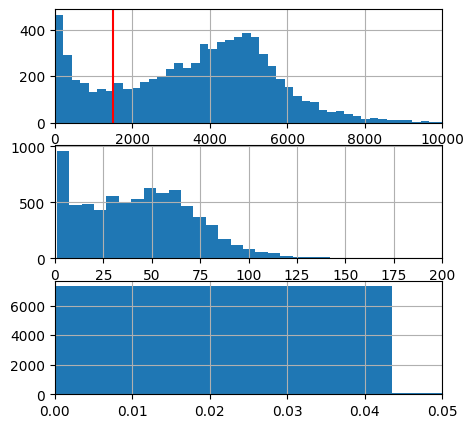

In [27]:
fig, ax = plt.subplots(3,1,figsize = (5,5))
buildings_per_block['building_per_km2'].hist(bins = 100,ax = ax[0])
ax[0].axvline(x = np.quantile(buildings_per_block['building_per_km2'],.2),color = 'r')
buildings_per_block['bin'].hist(bins = 100,ax = ax[1])
buildings_per_block['block_area_km2'].hist(bins = 100,ax = ax[2])
ax[0].set_xlim(0,10000)
ax[1].set_xlim(0,200)
ax[2].set_xlim(0,.05)

In [28]:
#group by the lot number and dissolve the geometry
building_block_bndry = building_gdf[building_gdf['building_per_km2']>np.quantile(buildings_per_block['building_per_km2'],.2)].dissolve(by="Block",aggfunc={"base_bbl": "count","bin": "count",'building_per_km2':"mean","block_area_km2":"mean"})

In [29]:
building_block_bndry.sort_values(by = 'base_bbl', ascending = False).head(20)

,geometry,base_bbl,bin,building_per_km2,block_area_km2
Block,,,,,
7405.0,"MULTIPOLYGON (((-73.95004 40.59311, -73.95004 ...",642,642,3565.693374,0.180049
7422.0,"MULTIPOLYGON (((-73.94944 40.59102, -73.94944 ...",569,569,3917.975471,0.145228
7441.0,"MULTIPOLYGON (((-73.94874 40.58823, -73.94910 ...",427,427,5174.760613,0.082516
6461.0,"MULTIPOLYGON (((-74.01352 40.60277, -74.01357 ...",408,408,8497.341791,0.048015
7104.0,"MULTIPOLYGON (((-73.97295 40.59732, -73.97294 ...",294,294,3372.209489,0.087183
6460.0,"MULTIPOLYGON (((-74.01561 40.60413, -74.01561 ...",281,281,5818.943994,0.048291
6681.0,"MULTIPOLYGON (((-73.97233 40.60210, -73.97215 ...",219,219,2477.954905,0.088379
7381.0,"MULTIPOLYGON (((-73.95000 40.59504, -73.95001 ...",209,209,4773.088492,0.043787
6463.0,"MULTIPOLYGON (((-74.00918 40.60083, -74.00914 ...",200,200,7283.404148,0.027460


In [30]:
building_block_bndry.sort_values(by = 'building_per_km2', ascending = False).head(20)

,geometry,base_bbl,bin,building_per_km2,block_area_km2
Block,,,,,
3233.0,"POLYGON ((-73.92550 40.69816, -73.92566 40.698...",1,1,21954.721138,0.000046
2229.0,"POLYGON ((-73.95922 40.69950, -73.95925 40.699...",1,1,21387.683406,0.000047
926.0,"POLYGON ((-73.97800 40.68451, -73.97799 40.684...",1,1,17479.133033,0.000057
5900.0,"MULTIPOLYGON (((-74.01677 40.62895, -74.01674 ...",19,19,13462.820356,0.001411
3914.0,"MULTIPOLYGON (((-73.88122 40.68475, -73.88122 ...",4,4,12768.135720,0.000313
3945.0,"POLYGON ((-73.88102 40.68118, -73.88105 40.681...",5,5,12343.956040,0.000405
4990.0,"MULTIPOLYGON (((-73.93554 40.63794, -73.93554 ...",171,171,11605.229522,0.014735
4989.0,"MULTIPOLYGON (((-73.93632 40.63761, -73.93632 ...",166,166,11362.814414,0.014609
7307.0,"MULTIPOLYGON (((-73.94428 40.60357, -73.94428 ...",169,169,11197.980331,0.015092


In [31]:
building_block_bndry.sort_values(by = 'block_area_km2', ascending = False).head(20)

,geometry,base_bbl,bin,building_per_km2,block_area_km2
Block,,,,,
7405.0,"MULTIPOLYGON (((-73.95004 40.59311, -73.95004 ...",642,642,3565.693374,0.180049
7422.0,"MULTIPOLYGON (((-73.94944 40.59102, -73.94944 ...",569,569,3917.975471,0.145228
6681.0,"MULTIPOLYGON (((-73.97233 40.60210, -73.97215 ...",219,219,2477.954905,0.088379
7104.0,"MULTIPOLYGON (((-73.97295 40.59732, -73.97294 ...",294,294,3372.209489,0.087183
7441.0,"MULTIPOLYGON (((-73.94874 40.58823, -73.94910 ...",427,427,5174.760613,0.082516
8374.0,"MULTIPOLYGON (((-73.90911 40.62458, -73.90908 ...",107,107,2020.181661,0.052966
8369.0,"MULTIPOLYGON (((-73.91288 40.62273, -73.91290 ...",111,111,2112.786885,0.052537
6821.0,"MULTIPOLYGON (((-73.95734 40.60485, -73.95742 ...",77,77,1588.173642,0.048483
6460.0,"MULTIPOLYGON (((-74.01561 40.60413, -74.01561 ...",281,281,5818.943994,0.048291


<Axes: >

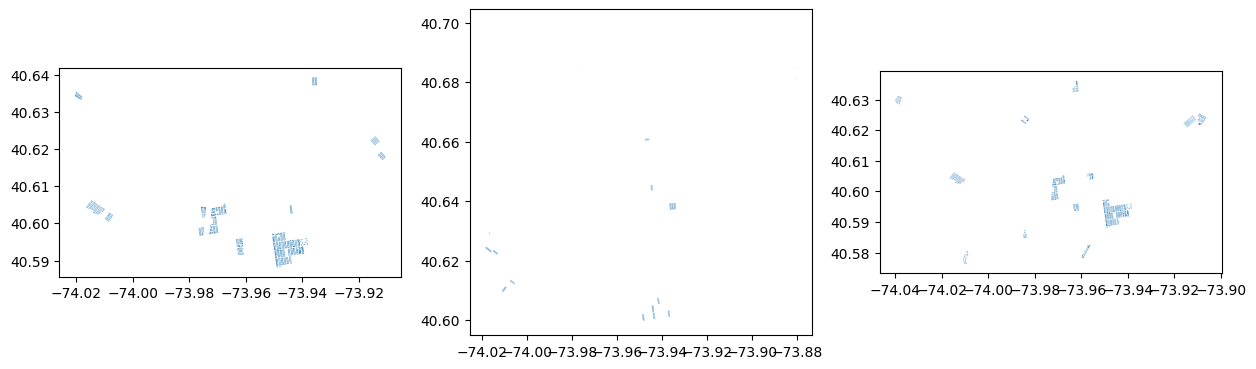

In [32]:
fig, ax = plt.subplots(1,3,figsize = (15,15))
building_block_bndry.sort_values(by = 'base_bbl', ascending = False).head(20).plot(ax = ax[0])
building_block_bndry.sort_values(by = 'building_per_km2', ascending = False).head(20).plot(ax = ax[1])
building_block_bndry.sort_values(by = 'block_area_km2', ascending = False).head(20).plot(ax = ax[2])


In [33]:
print(len(building_gdf),len(building_block_bndry))

330954 5982


<Axes: >

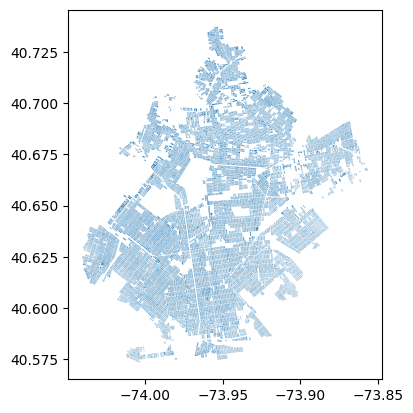

In [34]:
building_block_bndry.plot()

In [35]:
s = building_block_bndry.geometry.convex_hull
s.head()

Block
20.0    POLYGON ((-73.98473 40.70375, -73.98595 40.703...
30.0    POLYGON ((-73.98694 40.70317, -73.98717 40.703...
34.0    POLYGON ((-73.98033 40.70311, -73.98075 40.703...
35.0    POLYGON ((-73.99323 40.70255, -73.99325 40.702...
42.0    POLYGON ((-73.98292 40.70237, -73.98433 40.702...
dtype: geometry

In [36]:
type(s)

geopandas.geoseries.GeoSeries

<Axes: >

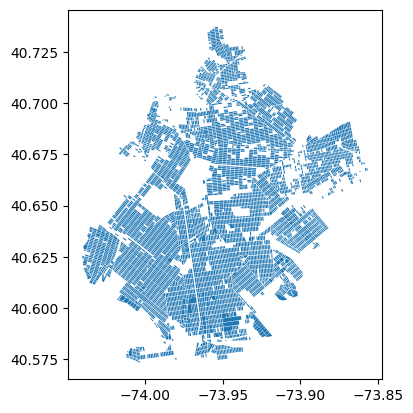

In [37]:
s.plot()

In [38]:
non_dissolve = building_gdf[building_gdf['building_per_km2']<=np.quantile(buildings_per_block['building_per_km2'],.2)]
s2 = non_dissolve.geometry.convex_hull
s2.head()

16     POLYGON ((-73.87136 40.65715, -73.87143 40.657...
22     POLYGON ((-73.95065 40.69935, -73.95071 40.699...
48     POLYGON ((-73.92970 40.67479, -73.92976 40.674...
131    POLYGON ((-73.91488 40.61023, -73.91491 40.610...
132    POLYGON ((-73.87179 40.65517, -73.87186 40.655...
dtype: geometry

<Axes: >

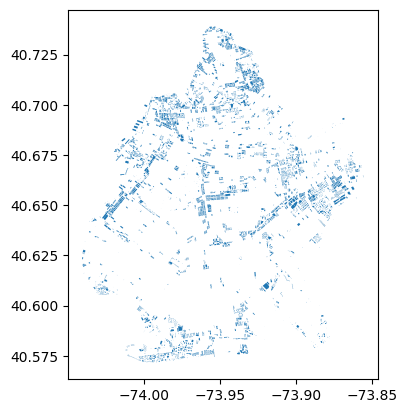

In [39]:
s2.plot()

In [40]:
total_dissolve = pd.concat([s,s2])
total_dissolve.head()

20.0    POLYGON ((-73.98473 40.70375, -73.98595 40.703...
30.0    POLYGON ((-73.98694 40.70317, -73.98717 40.703...
34.0    POLYGON ((-73.98033 40.70311, -73.98075 40.703...
35.0    POLYGON ((-73.99323 40.70255, -73.99325 40.702...
42.0    POLYGON ((-73.98292 40.70237, -73.98433 40.702...
dtype: geometry

<Axes: >

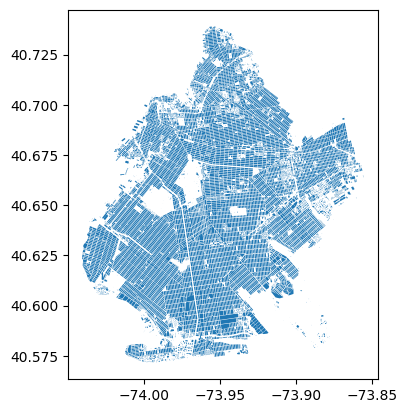

In [41]:
total_dissolve.plot()

In [42]:
if not os.path.exists('../Data/bk_building_block_boundary_top75pec'):
    os.makedirs('../Data/bk_building_block_boundary_top75pec')
    print("Directory created successfully")
else:
    print("Directory already exists")
s.to_file('../Data/bk_building_block_boundary_top75pec/bk_building_block_boundary_top75pec.shp')

Directory already exists


In [43]:
if not os.path.exists('../Data/bk_building_block_boundary'):
    os.makedirs('../Data/bk_building_block_boundary')
    print("Directory created successfully")
else:
    print("Directory already exists")
total_dissolve.to_file('../Data/bk_building_block_boundary/bk_building_block_boundary.shp')

Directory already exists


In [45]:
building_bndry = building_gdf.dissolve(by="Block",aggfunc={"base_bbl": "count","bin": "count",'building_per_km2':"mean","block_area_km2":"mean"})

In [46]:
building_bndry.head()

,geometry,base_bbl,bin,building_per_km2,block_area_km2
Block,,,,,
1.0,"MULTIPOLYGON (((-73.98671 40.70448, -73.98742 ...",2,2,220.042177,0.009089
3.0,"MULTIPOLYGON (((-73.98521 40.70449, -73.98522 ...",15,15,373.968334,0.040110
5.0,"MULTIPOLYGON (((-73.98187 40.70488, -73.98186 ...",4,4,356.242109,0.011228
6.0,"MULTIPOLYGON (((-73.98002 40.70369, -73.98002 ...",10,10,281.117341,0.035572
7.0,"POLYGON ((-73.98926 40.70425, -73.98924 40.704...",1,1,177.737443,0.005626


<Axes: >

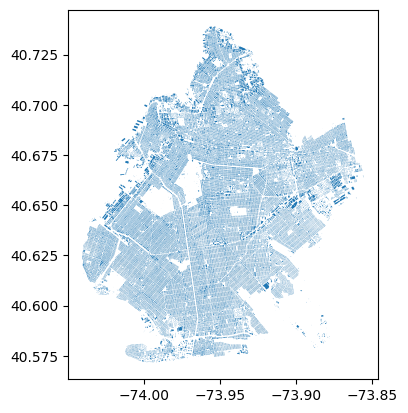

In [47]:
building_bndry.plot()

In [48]:
print(len(building_gdf),len(building_bndry))

330954 7478


In [ ]:
if not os.path.exists('../Data/bk_building_footprints'):
    os.makedirs('../Data/bk_building_footprints')
    print("Directory created successfully")
else:
    print("Directory already exists")
building_bndry.to_file('../Data/bk_building_footprints/bk_building_footprints.shp')

Directory already exists
